# GTHA housing market database
# OSEMN methodology Step 2: Scrub
# Step 2.2 Spatial join of Teranet points with Transportation Analysis Zones geometry

---

This notebook describes Step 2.2 (part of _Step 2: Scrub_ of OSEMN methodology) performed on the Teranet dataset.

Step 2.2 involves the spatial join of Teranet points with polygons of Transportation Analysis Zones (TAZ). It is performed to add new columns to each Teranet transaction from the TAZ in which it is located.

Previous steps included: 

* Step 2.1 

    * the spatial join between the Teranet points and the polygons of GTHA Dissemination Areas (DAs)
    
    * During step 2.1, Teranet records whose coordinates fall outside of the GTHA boundary (as defined by the DA geometry) have been filtered out (6,803,691 of the original 9,039,241 Teranet records remain in the dataset)
     
    * In addition to that, three new columns (`OBJECTID`, `DAUID`, and `CSDNAME`) derived from DA attributes have been added to each Teranet transaction

---

For description of OSEMN methodology, see `methodology/0.osemn/osemn.pdf`.

For background information, description of the Teranet dataset, and its attributes, see `methodology/1.obtain/obtain.pdf`.

For description of _Step 2: Scrub_ of OSEMN methodology, see `methodology/2.scrub/scrub.pdf`.

For description of the cleanup plan for Teranet dataset, see `methodology/2.scrub/teranet_cleanup_plan.pdf`.

For description of Step 2.1 of the cleanup process, see `notebooks/2.scrub/2.1_teranet_gtha_spatial_join.ipynb`.


## Import dependencies

In [1]:
%matplotlib inline
import pandas as pd 
import geopandas as gpd
import os
from shapely.geometry import Point
from time import time

In [2]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['1.1_Teranet_DA.csv',
 'parcel16_epoi13.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 'GTAjoinedLanduseSales']

In [3]:
data_path = '../../data/'
taz_path = data_path + 'taz/TAZ_2001shp/'
os.listdir(taz_path)

['TAZ_2001.dbf',
 'TAZ_2001.sbn',
 'TAZ_2001.shp',
 'TAZ_2001.shx',
 'TAZ_2001.cpg',
 'TAZ_2001.prj',
 'TAZ_2001.sbx']

## Load geometry of Traffic Analysis Zones (TAZ)

----- GeoDataFrame loaded
in 0.32 seconds
with 1,716 rows
and 5 columns
-- Column names:
 Index(['OBJECTID', 'Shape_Leng', 'Shape_Area', 'TAZ_O', 'geometry'], dtype='object')
Taking the subset with columns
: ['TAZ_O', 'geometry']

-- New column names:
 Index(['TAZ_O', 'geometry'], dtype='object')


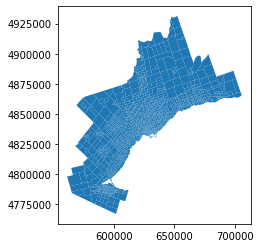

In [4]:
t = time()
taz_gdf = gpd.read_file(taz_path + 'TAZ_2001.shp')
elapsed = time() - t

print("----- GeoDataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(taz_gdf.shape[0], taz_gdf.shape[1]) + 
      "\n-- Column names:\n", taz_gdf.columns)
      
cols = ['TAZ_O', 'geometry']

print("Taking the subset with columns\n:", cols)

taz_gdf = taz_gdf[cols]

print("\n-- New column names:\n", taz_gdf.columns)

taz_gdf.plot();

## Load Teranet data

In [5]:
t = time()
teranet_df = pd.read_csv(teranet_path + '1.1_Teranet_DA.csv')
elapsed = time() - t
print("----- DataFrame loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_df.shape[0], teranet_df.shape[1]) + 
      "\n-- Column names:\n", teranet_df.columns)

t = time()
# combine values in columns 'x' and 'y' into a POINT geometry object
geometry = [Point(xy) for xy in zip(teranet_df['X'], teranet_df['Y'])]
# generate a new GeoDataFrame by adding point geometry to data frame 'teranet_sales_data'
teranet_gdf = gpd.GeoDataFrame(teranet_df, geometry=geometry)
elapsed = time() - t
print("\n----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_gdf.shape[0], teranet_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_gdf.columns)

# add CRS for WGS84 (lat-long) to GeoDataFrame with Teranet records
teranet_gdf.crs = {'proj': 'latlong', 
                   'ellps': 'WGS84', 
                   'datum': 'WGS84', 
                   'no_defs': True}
print("\n----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!")

----- DataFrame loaded
in 20.33 seconds
with 6,803,691 rows
and 19 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME'],
      dtype='object')

----- Geometry generated from 'X' and 'Y' pairs, GeoDataFrame created!
in 90.70 seconds (1.51 minutes)
with 6,803,691 rows
and 20 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'geometry'],
      dtype='object')

----- CRS dictionary for WGS84 added to geo data frame 'teranet_gdf'!


## Perform the spatial join of Teranet points with TAZ polygons
### Validate projections

In [6]:
teranet_gdf.crs

{'proj': 'latlong', 'ellps': 'WGS84', 'datum': 'WGS84', 'no_defs': True}

In [7]:
taz_gdf.crs

{'init': 'epsg:26917'}

### Convert TAZ CRS to EPSG:4326

In [8]:
taz_gdf = taz_gdf.to_crs(epsg=4326)
taz_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

### Perform the spatial join

In [9]:
t = time()
teranet_taz_gdf = gpd.sjoin(teranet_gdf.to_crs(taz_gdf.crs), taz_gdf, 
                           how='left', op='within')
elapsed = time() - t
print("\n----- Spatial join completed, new GeoDataFrame created"
      "\nin {0:.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(teranet_taz_gdf.shape[0], teranet_taz_gdf.shape[1]) + 
      "\n-- Column names:\n", teranet_taz_gdf.columns)


----- Spatial join completed, new GeoDataFrame created
in 868.68 seconds (14.48 minutes)
with 6,803,756 rows
and 22 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'POSTAL_CODE', 'PROVINCE', 'UNITNO', 'STREET_NAME',
       'STREET_DESIGNATION', 'STREET_DIRECTION', 'MUNICIPALITY',
       'STREET_SUFFIX', 'STREET_NUMBER', 'X', 'Y', 'DAUID', 'CSDUID',
       'CSDNAME', 'geometry', 'index_right', 'TAZ_O'],
      dtype='object')


### Remove duplicated Teranet records generated by the spatial join
Some Teranet points are located right at the boundary of the two different TAZ and thus get duplicated in the dataset. These duplicates are removed.
#### Examples of records duplicated by the spatial join

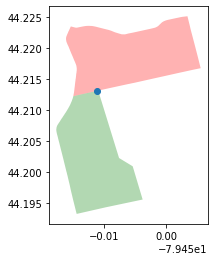

In [10]:
mask1 = taz_gdf['TAZ_O'] == 1340
ax = taz_gdf[mask1].plot(color='red', alpha=0.3)

mask1 = taz_gdf['TAZ_O'] == 1341
taz_gdf[mask1].plot(color='green', alpha=0.3, ax=ax);

mask1 = teranet_gdf['transaction_id'] == 261405
teranet_gdf[mask1].plot(ax=ax);

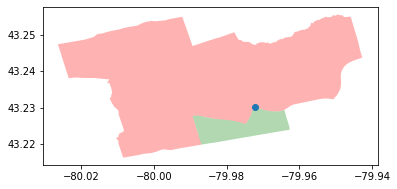

In [11]:
mask1 = taz_gdf['TAZ_O'] == 2625
ax = taz_gdf[mask1].plot(color='red', alpha=0.3)

mask1 = taz_gdf['TAZ_O'] == 2641
taz_gdf[mask1].plot(color='green', alpha=0.3, ax=ax);

mask1 = teranet_gdf['transaction_id'] == 134642
teranet_gdf[mask1].plot(ax=ax);

#### Remove duplicate records from the GeoDataFrame

In [12]:
old_len = len(teranet_taz_gdf)
teranet_taz_gdf = teranet_taz_gdf.drop_duplicates(subset='transaction_id')
print("{0:,} records were dropped. {1:,} records remain in the GeoDataFrame."
      .format(old_len - len(teranet_taz_gdf), len(teranet_taz_gdf)))

65 records were dropped. 6,803,691 records remain in the GeoDataFrame.


### Save results to a .csv file

In [13]:
save_path = teranet_path + '1.2_Teranet_DA_TAZ.csv'
t = time()
teranet_taz_gdf.drop(['index_right', 'geometry'], axis=1).to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds".format(elapsed))

DataFrame saved to file:
 ../../data/teranet/1.2_Teranet_DA_TAZ.csv 
took 143.21 seconds
